In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

import gpflow
from gpflow.utilities import print_summary, positive

import tensorflow as tf
from tensorflow import math as tfm
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow_probability import mcmc

from load_puma_data import load_barenco_puma
import math
import random

PI = tf.constant(math.pi, dtype='float64')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df, genes, genes_se, Y, Y_var = load_barenco_puma()


N_m = 7               # Number of observations
def calc_N_p(N_p, num_disc=8):
    '''A helper recursive function to ensure t is a subset of τ'''
    if num_disc <= 0:
        return N_p
    return N_p -1 + calc_N_p(N_p, num_disc-1)
num_disc = 10
N_p = calc_N_p(N_m, num_disc)  # Number of time discretisations
common_indices = np.array([i*num_disc+i for i in range(N_m)])
t = np.arange(N_m)*2           # Observation times
τ = np.linspace(0, 12, N_p, dtype='float32')    # Discretised observation times
num_genes = 5
I = 1 # Number of TFs

m_observed = np.float32(Y[:-1])
f_observed = np.float32(np.atleast_2d(Y[-1]))
σ2 = np.float32(Y_var[:-1])
σ2_f = np.float32(np.atleast_2d(Y_var[-1]))

## Metropolis Hastings Custom MCMC Algorithm

In [3]:
# Parameters
params = None
w_j0 = 1    # Interaction bias (TODO)
fbar_i = 0.5*np.ones(N_p, dtype='float32')
v_i = 1 # Fix this to 1 if translation model is not used (pg.8)
l2_i = 0.1
δbar_i = np.float32(0.1)
h_δ = 1
h_c = 0.3
h_f = 0.4*tf.ones(N_p, dtype='float32')
h_k = 0.1*tf.ones(4, dtype='float32')
h_w = tf.ones(num_genes, dtype='float32')
h_σm = tf.constant(0.8, dtype='float32')
a = tf.constant(-0.5, dtype='float32')
b2 = tf.constant(2., dtype='float32')
w_j = 0.5*np.ones((num_genes, I))
σ2_m = 1e-2*np.ones(num_genes, dtype='float32')
kbar_i = 0.1*np.float32(np.c_[np.ones(num_genes), # a_j
                          np.ones(num_genes), # b_j
                          np.ones(num_genes), # d_j
                          np.ones(num_genes)])# s_j
def fixed(kbar, gene):
    if gene == 3:
        kbar[2] = np.log(0.8)
        kbar[3] = np.log(1.0)
    kbar[kbar < -10] = -10
    kbar[kbar > 2] = 2
    return kbar
kbar_i[3] = fixed(kbar_i[3], 3)


In [4]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

def get_rbf_dist(times, N):
    t_1 = np.reshape(np.tile(times, N), [N, N]).T
    t_2 = np.reshape(np.tile(times, N), [N, N])
    return t_1-t_2

# Priors
def l2_prior(l2):
    return tfd.InverseGamma(0.1, 0.1).log_prob(l2) # TODO
def v_prior(v):
    return tfd.InverseGamma(0.1, 0.1).log_prob(v)
def σ2_m_prior(σ):
    return tfd.InverseGamma(0.01, 0.01).log_prob(σ)

def w_j_prior(w_j): # At the moment this is the same as w_j0 (see pg.8)
    return tfd.Normal(0, 2).log_prob(w_j0)
def w_j0_prior(w_j0):
    return tfd.Normal(0, 2).log_prob(w_j0)
    
def kbar_prior(kbar):
    return np.prod(tfd.Normal(a, b2).log_prob(kbar))

def fbar_prior_params(v=v_i, l2=l2_i):
    t_dist = get_rbf_dist(τ, N_p)
#     print('vl2', v, l2)
    jitter = tf.linalg.diag(1e-5 * np.ones(N_p, dtype='float32'))
    K = v * np.exp(-np.square(t_dist)/(2*l2)) + jitter
#     print(K)
    m = np.zeros(N_p, dtype='float32')
    return m, K

def fbar_prior(fbar, v=v_i, l2=l2_i):
    m, K = fbar_prior_params(v, l2)
    try:
        prob = np.float64(tfd.MultivariateNormalFullCovariance(m, K).prob(fbar))
        return prob
    except:
        jitter = tf.linalg.diag(1e-4 * np.ones(N_p, dtype='float32'))
        try:
            prob = np.float64(tfd.MultivariateNormalFullCovariance(m, K+jitter).log_prob(fbar))
            return prob
        except:
            return 0

def δbar_prior(δ):
    return np.float64(tfd.Normal(a, b2).log_prob(δ))

# Likelihoods
def predict_m(kbar, δbar, w, fbar):
    # Take relevant parameters out of log-space
    a_j, b_j, d_j, s_j = (np.exp(kbar_i[:, i]).reshape(-1, 1) for i in range(4))
    δ = np.exp(δbar)
    f_i = np.log(1+np.exp(fbar))
#     print('f_i', f_i)

    # Calculate p_i vector
    p_i = np.zeros(N_p) # TODO it seems the ODE translation model has params A, S see gpmtfComputeTFODE
    Δ = τ[1]-τ[0]
    sum_term = np.exp(δ*τ) * f_i
    p_i[1:] = 0.5*Δ*np.cumsum(sum_term[:-1] + sum_term[1:]) # Trapezoid rule
    p_i = np.exp(-δ*τ) * p_i

#     print('pi', p_i)

    # Calculate m_pred
    integrals = np.zeros((num_genes, N_p), dtype='float32')
    interactions = w_j[:, 0][:, None]*np.log(p_i+1e-50) + w_j0    
    G = 1/(1+np.exp(-interactions)) # TF Activation Function
    sum_term = G * np.exp(d_j*τ)
    integrals[:, 1:] = 0.5*Δ*np.cumsum(sum_term[:, :-1] + sum_term[:, 1:], axis=1) # Trapezoid rule
    exp_dt = np.exp(-d_j*τ)
    integrals = exp_dt * integrals
    m_pred = b_j/d_j + (a_j-b_j/d_j)*exp_dt + s_j*integrals

    return m_pred

def m_likelihood(δbar=None, 
                 fbar=None, 
                 kbar=None, 
                 w=None,
                 σ=None,
                 changed=True):
    if δbar is None:
        δbar = δbar_i
    if fbar is None:
        fbar = fbar_i
    if kbar is None:
        kbar = kbar_i
    if w is None:
        w = w_j
    if σ is None:
        σ = σ2_m

    m_pred = predict_m(kbar, δbar, w, fbar)
    
    log_lik = np.zeros(num_genes)
    sq_diff = np.square(m_observed - m_pred[:, common_indices])
    variance = σ2_m.reshape(-1, 1) + σ2 # add PUMA variance
    log_lik = -0.5*np.log(2*np.pi*(variance)) - 0.5*sq_diff/variance
    log_lik = np.sum(log_lik, axis=1)
    
#     t_dist = get_rbf_dist(t, N_m)        # RBF covariance
#     jitter = tf.linalg.diag(1e-5 * np.ones(N_m, dtype='float32'))
#     K = 1 * np.exp(-np.square(t_dist)/(2*1)) + jitter # TODO replace v, l2
#     for j in range(num_genes):
#         K_j = K + tf.linalg.diag(σ2[j])
#         L = tf.linalg.cholesky(K_j)
#         d = diff[j][:, None]
#         alpha = tf.linalg.triangular_solve(L, d, lower=True)
#         num_dims = tf.cast(tf.shape(d)[0], L.dtype)
#         p = -0.5 * tf.reduce_sum(tf.square(alpha), 0)
#         p -= 0.5 * num_dims * np.log(2 * np.pi)
#         p -= tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L)))
#         lik[j] = p
    
    return log_lik

def f_likelihood(fbar, i=0): 
    '''TODO this should be for the i-th TF'''
    f_i = np.log(1+np.exp(fbar))
    f_i = np.float32(np.atleast_2d(f_i[common_indices]))
#     print(f_i[i], f[i])
    prob = tfd.Normal(f_observed[i], σ2_f[i]).log_prob(f_i[i])
#     print('prob', prob)
    lik = tf.reduce_sum(prob)
    return lik

old_m_likelihood = None
old_m_likelihood = m_likelihood(changed=True)
print(old_m_likelihood)

[-55.26649 -39.60661 -58.60328 -113.80577 -12.45850]


In [7]:
fbar = np.zeros(N_p)
fbar[common_indices] = np.log(np.exp(f_observed)-1)

print('-------')
print(m_likelihood(), f_likelihood(fbar_i))
print('------')
print(m_likelihood(fbar=fbar), f_likelihood(fbar))

-------
[-2104.45947 -3676.81812 -1500.78296 -2725.19385 -103.46115] tf.Tensor(-25.826548, shape=(), dtype=float32)
------
[-2299.62354 -3897.24902 -1500.69897 -2787.02148 -103.92024] tf.Tensor(-0.4992845, shape=(), dtype=float32)


In [5]:
def is_accepted(new_log_prob, old_log_prob):
    alpha = np.exp(new_log_prob - old_log_prob)
    if tf.is_tensor(alpha):
        alpha = alpha.numpy()
    return not np.isnan(alpha) and random.random() < min(1, alpha)

----- Metropolis Begins -----
k [[1.10517 1.10517 1.10517 1.10517]
 [1.10517 1.10517 1.10517 1.10517]
 [1.10517 1.10517 1.10517 1.10517]
 [1.10517 1.10517 0.80000 1.00000]
 [1.10517 1.10517 1.10517 1.10517]]


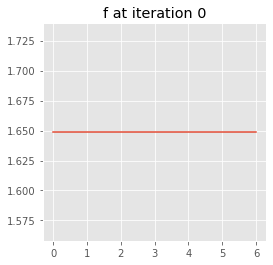

c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in exp
c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in multiply


k [[3.17704 2.81948 0.88659 5.51415]
 [2.86934 4.65667 1.00296 2.36131]
 [2.62668 4.66039 7.38906 7.09797]
 [5.71697 3.96118 0.80000 1.00000]
 [3.64278 4.60393 2.32881 1.78265]]


KeyboardInterrupt: 

In [6]:
print('----- Metropolis Begins -----')
clear_params = False
if params is None or clear_params:
    params = {'δ': list(), 
              'k': [list() for _ in range(num_genes)],
              'σ': [list() for _ in range(num_genes)],
              'w': [list() for _ in range(num_genes)],
              'L': list(),
              'V': list()
             }
T = 1000

for iteration_number in range(T):
    if iteration_number % 50 == 0:
        print(f'{100*iteration_number/T:.2f}% complete', end='\r')
        print('k', np.exp(kbar_i))
    if iteration_number % 500 == 0:
        f_plot = np.exp(fbar_i)
        f_plot = [f_plot[i*num_disc+i] for i in range(N_m)]
        plt.figure(figsize=(4, 4))
        plt.plot(f_plot)
        plt.title(f'f at iteration {iteration_number}')
        plt.show()

    # Compute likelihood for comparison
    old_m_likelihood = m_likelihood()
    
    # Untransformed tf mRNA vectors F
    for i in range(I):
        # Gibbs step
        z_i = tf.reshape(tfd.MultivariateNormalDiag(fbar_i, h_f).sample(), (1, -1))
        # MH
        m, K = fbar_prior_params()
        invKsigmaK = tf.matmul(tf.linalg.inv(K+tf.linalg.diag(h_f)), K) # (C_i + hI)C_i
        L = tf.linalg.cholesky(K-tf.matmul(K, invKsigmaK))
        c_mu = tf.matmul(z_i, invKsigmaK)
        fstar = tf.matmul(tf.random.normal((1, L.shape[0])), L) + c_mu
        fstar = tf.reshape(fstar, (-1, ))
#         print(fstar)
        new_prob = np.sum(m_likelihood(fbar=fstar)) + f_likelihood(fstar)
        old_prob = np.sum(old_m_likelihood) + f_likelihood(fbar_i)
#         print(m_likelihood(fbar=fstar), m_likelihood(fbar=fbar_i))
#         print(g(fstar), g(fbar_i))
        if is_accepted(new_prob, old_prob):
#             print('f accepted')
            fbar_i = fstar


    # Log of translation ODE degradation rates
    for i in range(I):
        # Proposal distribution
        Q = tfd.Normal(δbar_i, h_δ)
        δstar = Q.sample() # δstar is in log-space, i.e. δstar = δbar*
        new_prob = np.sum(m_likelihood(δbar=δstar)) + δbar_prior(δstar)
        old_prob = np.sum(old_m_likelihood) + δbar_prior(δbar_i)
        if is_accepted(new_prob, old_prob):
            δbar_i = δstar
            params['δ'].append(δstar)

            
    # Log of transcription ODE kinetic params
    kstar = kbar_i.copy()
    for j in range(num_genes):
        Q = tfd.MultivariateNormalDiag(kbar_i[j], h_k)
        sample = fixed(Q.sample().numpy(), j)
        kstar[j] = sample
        g = lambda kbar: m_likelihood(kbar=kbar)[j] + kbar_prior(kbar)
        if is_accepted(g(kstar), g(kbar_i)):
            kbar_i[j] = kstar[j]
            params['k'][j].append(kstar[j])
        else:
            kstar[j] = kbar_i[j]

    
    # Interaction weights and biases
    wstar = w_j.copy()
    for j in range(num_genes):
        Q = tfd.Normal(w_j[j], 0.1)#h_w[j])
        sample = Q.sample()[0]
        wstar[j] = sample
        new_prob = m_likelihood(w=wstar)[j] + w_j_prior(sample)
        old_prob = old_m_likelihood[j] + w_j_prior(w_j[j][0])
#         print('----')
#         print(g(wstar))
#         print(g(w_j[j][0]))
        if is_accepted(new_prob, old_prob):
            w_j[j] = sample
            params['w'][j].append(sample)
        else:
            wstar[j] = w_j[j]

    for j in range(num_genes):
        Q = lambda σ: tfd.TruncatedNormal(σ, h_σm, low=0, high=5)
        sample = Q(σ2_m[j]).sample()
        σ2_mstar = σ2_m.copy()
        σ2_mstar[j] = sample
        new_prob = m_likelihood(σ=σ2_mstar)[j] + σ2_m_prior(σ2_mstar[j]) + Q(σ2_mstar[j]).log_prob(σ2_m[j])
        old_prob: m_likelihood(σ=σ2_m)[j] + σ2_m_prior(σ2_m[j]) + Q(σ2_m[j]).log_prob(σ2_mstar[j])
        if is_accepted(new_prob, old_prob):
            σ2_m[j] = σ2_mstar[j]
            params['σ'][j].append(σ2_mstar[j])
    
    # Length scales and variances of GP kernels
    for i in range(I):
        Q_v = lambda v: tfd.TruncatedNormal(v, l2_i, low=0, high=100)
        Q_l = lambda l2: tfd.TruncatedNormal(l2, h_c, low=0, high=100)
        vstar = Q_v(v_i).sample()
        l2star = Q_l(l2_i).sample()
#         print(vstar, l2star, 'prior', fbar_prior(fbar_i, vstar, l2star))
        g = lambda v, l2, v_other, l2_other: fbar_prior(fbar_i, v, l2) + \
            v_prior(v) + l2_prior(l2) + Q_v(v_other).log_prob(v) + Q_l(l2_other).log_prob(l2)
#         print(g(v_i, l2_i, vstar, l2star))
        if is_accepted(g(vstar, l2star, v_i, l2_i), g(v_i, l2_i, vstar, l2star)):
#             print("accepted")
            v_i = vstar
            l2_i = l2star
            params['V'].append(vstar)
            params['L'].append(l2star)

print('----- Finished -----')


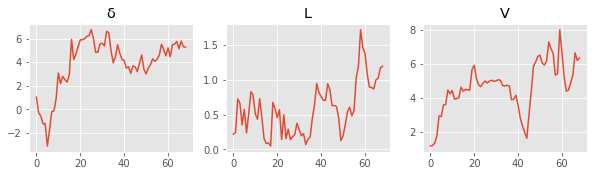

In [102]:
# Plot decay
plt.figure(figsize=(10, 8))
for i, param in enumerate(['δ', 'L', 'V']):
    ax = plt.subplot(331+i)
    plt.plot(params[param])
    ax.set_title(param)
#'σ', 'w']):


(43, 4)
(43, 4)
(46, 4)
(41, 4)
(50, 4)


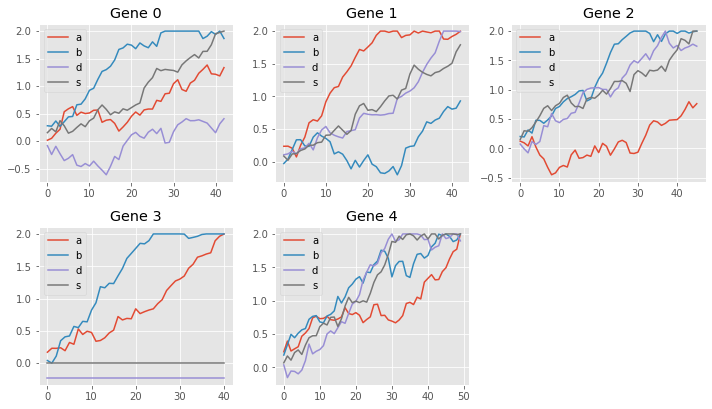

In [103]:
# Plot transcription ODE kinetic params
plt.figure(figsize=(10, 14))
plt.title('Transcription ODE kinetic parameters')
labels = ['a', 'b', 'd', 's']
for j in range(num_genes):
    ax = plt.subplot(num_genes, num_genes-2, j+1)
    k_param = np.array(params['k'][j])
    print(k_param.shape)
    
    for k in range(4):
        plt.plot(k_param[:, k], label=labels[k])
    plt.legend()
    ax.set_title(f'Gene {j}')

plt.tight_layout()


c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


(5, 67)


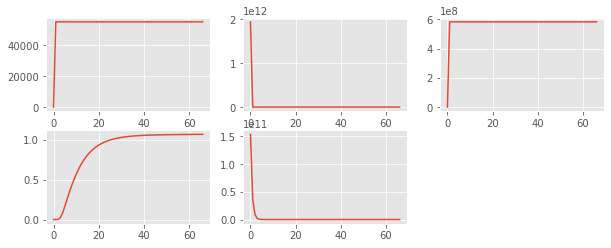

In [248]:
# Plot genes
plt.figure(figsize=(10, 10))
m_pred = predict_m(kbar_i, δbar_i, w_j, fbar_i)
print(m_pred.shape)
for j in range(num_genes):
    plt.subplot(531+j)
    plt.plot(m_pred[j, :])

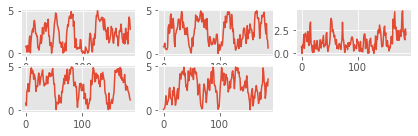

In [218]:
plt.figure(figsize=(7, 5))
plt.title('Noise variances')
for i, j in enumerate(range(num_genes)):
    ax = plt.subplot(num_genes, num_genes-2, i+1)
    plt.plot(params['σ'][j]);

[5.6298995, 2.4268727, 3.322251, 3.815366, 2.289182, 2.128737, 0.62264615]


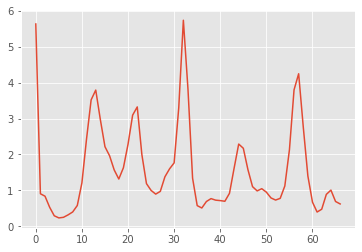

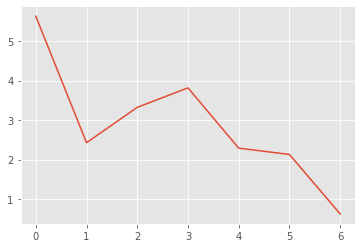

In [104]:
f_i = np.exp(fbar_i)
plt.plot(f_i)
plt.figure()
f_i = [f_i[i*num_disc+i] for i in range(N_m)]
print(f_i)
plt.plot(f_i)


In [252]:
kernel = gpflow.kernels.RBF() + gpflow.kernels.White(variance=0.01)

model = gpflow.models.SGPMC(
    data,
    kernel=kernel,
    likelihood=gpflow.likelihoods.MultiClass(3),
    inducing_variable=X[::5].copy(),
    num_latent_gps=3,
)
model.kernel.kernels[0].variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.kernels[0].lengthscales.prior = tfd.Gamma(f64(2.0), f64(2.0))
set_trainable(model.kernel.kernels[1].variance, False)

gpflow.utilities

NameError: name 'data' is not defined